# Parking Ticket Price Prediction
# Capstone Project
## Step1
## Exploratory Data Analysis and Baseline Models

### Alla B.
Email: allaboyers@gmail.com

### November 26, 2023

### Table of Contents
1. [Overview](#Overview)
2. [Explanation of the Data](#Explanation-of-the-Data)
    - [Importing Libraries](#Importing-Libraries)
    - [Exploring the Dataset](#Exploring-the-Dataset)
    - [Cleaning and Feature Engineering](#Cleaning-and-Feature-Engineering)
    - [Address to Lat and Lon](#Address-to-Lat-and-Lon)
3. [EDA and Data Preprocessing](#EDA-and-Data-Preprocessing)
4. [Modelling](#Modelling)
    - [Baseline Models](#Baseline-Models)
    - [Functions](#Functions)
    - [Experimenting With Other Algorithms](#Experimenting-With-Other-Algorithms)
    - [RandomForest](#RandomForest)
    - [AdaBoost](#AdaBoost)
    - [XGBoost](#XGBoost)
5. [SUMMARY:](#SUMMARY:)

## Overview

Parking tickets across the city generate millions in revenue for the City of Toronto every year. Even though the City of Toronto's revenue from parking tickets has gone up slightly in the last 2-3 years, after Covid-19, it has been declining since 2019. There is an opportunity to reverse this decline by making the City of Toronto's Administrative Penalty System (APS) more efficient. Using machine learning can enhance the efficiency of the APS.The impact of an efficient model can make the city safer and more attractive to residents and tourists. 

## Explanation of the Data

The dataset for this project will be sourced from the [Open Data Portal of the City of Toronto](https://open.toronto.ca/dataset/parking-tickets/) (2020-2022). The dataset contains non-identifiable information relating to each parking ticket issued for each calendar year. The tickets are issued by Toronto Police Services (TPS) personnel as well as persons certified and authorized to issue tickets by TPS. 

| ITEM   NAME            | DESCRIPTION                                                  |
|------------------------|--------------------------------------------------------------|
|                        |                                                              |
| TAG_NUMBER_MASKED      | First three (3) characters masked   with asterisks           |
| DATE_OF_INFRACTION     | Date the infraction   occurred in YYYYMMDD format            |
| INFRACTION_CODE        | Applicable Infraction   code (numeric)                       |
| INFRACTION_DESCRIPTION | Short description of   the infraction                        |
| SET_FINE_AMOUNT        | Amount of set fine   applicable (in dollars)                 |
| TIME_OF_INFRACTION     | Time the infraction   occurred  in HHMM format (24-hr clock) |
| LOCATION1              | Code to denote   proximity (see table below)                 |
| LOCATION2              | Street address                                               |
| LOCATION3              | Code to denote   proximity (optional)                        |
| LOCATION4              | Street address   (optional)                                  |
| PROVINCE               | Province or state   code of vehicle licence plate            |
|                        |                                                              |
|                        |                                                              |
| Proximity Code Table   |                                                              |
| PROXIMITY CODE         | DESCRIPTION                                                  |
| AT                     | At                                                           |
| NR                     | Near                                                         |
| OPP                    | Opposite                                                     |
| R/O                    | Rear   of                                                    |
| N/S                    | North   Side                                                 |
| S/S                    | South   Side                                                 |
| E/S                    | East   Side                                                  |
| W/S                    | West   Side                                                  |
| N/O                    | North   of                                                   |
| S/O                    | South   of                                                   |
| E/O                    | East   of                                                    |
| W/O                    | West   of                                                    |

## Importing Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
import json
from IPython.display import display

## Exploring the Dataset

In [2]:
# import the .csv files
data_path = '/parking_tickets_all/'
df = pd.concat([
    pd.read_csv(os.path.join(data_path,file_path), dtype={'time_of_infraction': str})
    for file_path in os.listdir(data_path)
])
# check first 5 rows
df.head()

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,0001,NaN,4700 JANE ST,NaN,NaN,SK
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,0002,OPP,573 CLENDENAN AVE,NaN,NaN,ON
2,***46474,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,0002,NR,573 CLENDENAN AVE,NaN,NaN,ON
3,***46475,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,0004,NR,21 MARIA ST,NaN,NaN,ON
4,***46674,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,0004,NR,164 GLENHOLME AVE,NaN,NaN,ON


In [3]:
# check the dataset
df.shape

(4707259, 11)

There are 4707259 rows and 11 columns.

In [4]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4707259 entries, 0 to 71887
Data columns (total 11 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   tag_number_masked       object
 1   date_of_infraction      int64 
 2   infraction_code         int64 
 3   infraction_description  object
 4   set_fine_amount         int64 
 5   time_of_infraction      object
 6   location1               object
 7   location2               object
 8   location3               object
 9   location4               object
 10  province                object
dtypes: int64(3), object(8)
memory usage: 431.0+ MB


## Cleaning and Feature Engineering 

In [5]:
# check for duplicates
df.duplicated().sum()

4

In [6]:
# drop duplicate rows
df = df.drop_duplicates()

In [7]:
# check
df.shape

(4707255, 11)

There are 4707254 rows (initial 4707259 minus 4 duplicates) and 11 columns.

In [8]:
# check for missing values
df.isnull().sum()

tag_number_masked               0
date_of_infraction              0
infraction_code                 0
infraction_description          0
set_fine_amount                 0
time_of_infraction           3159
location1                  607130
location2                     311
location3                 4329547
location4                 4328905
province                        0
dtype: int64

We have missing values in `time_of_infraction` and `location` columns. Main location column `location2` has only 311 missing values which is a very small number compared to the total dataset. The other location columns are optional and contain proximity code or intersection street name. I will drop optional location columns since we don't need them for future analysis.



In [9]:
# drop unnecessary location columns
df = df.drop(["location1", "location3", "location4"], axis = 1)
df = df.rename(columns = {"location2":"location"})
# check
df.head(3)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location,province
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,0001,4700 JANE ST,SK
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,0002,573 CLENDENAN AVE,ON
2,***46474,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,0002,573 CLENDENAN AVE,ON


Let's check percentage of missing values of the`time_of_infraction` column.

In [10]:
# check percentage of null values
df['time_of_infraction'].isna().sum()/df.shape[0]*100

0.0671091750924902

- Missing values account for only 0.067 percent of the total values. We can drop the missing rows.

In [11]:
# drop null values
df.dropna(subset = ['time_of_infraction'], inplace=True)

Let's check `time of infraction` column. It needs to be converted to datetime for further analysis. 

In [12]:
# check
df['time_of_infraction'].head()

0    0001
1    0002
2    0002
3    0004
4    0004
Name: time_of_infraction, dtype: object

In [13]:
# write a function to convert time_of_infraction to proper time format
from datetime import datetime
def transform_time(x):
    try:
        time = datetime.strptime(x[:2] + ':' + x[-2:], '%H:%M').time()
    except:
        time = None
    
    return time

In [14]:
# apply the function
df['time_of_infraction'] = df['time_of_infraction'].apply(transform_time)
# check
df.head(3)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location,province
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,00:01:00,4700 JANE ST,SK
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,00:02:00,573 CLENDENAN AVE,ON
2,***46474,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,00:02:00,573 CLENDENAN AVE,ON


In [15]:
# check 
df.isnull().sum()

tag_number_masked           0
date_of_infraction          0
infraction_code             0
infraction_description      0
set_fine_amount             0
time_of_infraction         10
location                  262
province                    0
dtype: int64

Ten rows didn't correspont to time format. Drop those 10 values.

In [16]:
# drop null values 
df.dropna(subset = ['time_of_infraction'], inplace=True)
# check again
df["time_of_infraction"].isnull().sum()

0

In [17]:
# split time_of_infraction to hh and mm for further analysis and modelling
df['hour'] = df['time_of_infraction'].apply(lambda x : x.hour)
df['min'] = df['time_of_infraction'].apply(lambda x : x.minute)
df = df.drop("time_of_infraction", axis = 1)
# check
df.head(2)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,location,province,hour,min
0,***60020,20200101,3,PARK ON PRIVATE PROPERTY,30,4700 JANE ST,SK,0,1
1,***46473,20200101,29,PARK PROHIBITED TIME NO PERMIT,30,573 CLENDENAN AVE,ON,0,2


Convert `date_of_infraction` to datetime.

In [18]:
# convert to datetime
df['date_of_infraction'] = pd.to_datetime(df['date_of_infraction'], format='%Y%m%d')
# check
df.head(2)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,location,province,hour,min
0,***60020,2020-01-01,3,PARK ON PRIVATE PROPERTY,30,4700 JANE ST,SK,0,1
1,***46473,2020-01-01,29,PARK PROHIBITED TIME NO PERMIT,30,573 CLENDENAN AVE,ON,0,2


In [19]:
# split date_of_infraction to Day, Month and Year for further analysis and modelling
df['Day'] = df['date_of_infraction'].dt.day
df['Month'] = df['date_of_infraction'].dt.month
df['Year'] = df['date_of_infraction'].dt.year
# check
df.head(2)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,location,province,hour,min,Day,Month,Year
0,***60020,2020-01-01,3,PARK ON PRIVATE PROPERTY,30,4700 JANE ST,SK,0,1,1,1,2020
1,***46473,2020-01-01,29,PARK PROHIBITED TIME NO PERMIT,30,573 CLENDENAN AVE,ON,0,2,1,1,2020


In [20]:
# drop original date_of_infraction column
df = df.drop("date_of_infraction", axis =1)
# check
df.head(2)

,tag_number_masked,infraction_code,infraction_description,set_fine_amount,location,province,hour,min,Day,Month,Year
0,***60020,3,PARK ON PRIVATE PROPERTY,30,4700 JANE ST,SK,0,1,1,1,2020
1,***46473,29,PARK PROHIBITED TIME NO PERMIT,30,573 CLENDENAN AVE,ON,0,2,1,1,2020


## Address to Lat and Lon

We need to convert addresses to Latitude and Longitude to use it in further analysis.
ref: [Openstreetmap-nominatim](https://byteshiva.medium.com/how-to-retrieve-latitude-and-longitude-using-pythons-requests-library-and-openstreetmap-nominatim-7cd286d38aee)
Open street map Nominatim will be used to convert addresses to Latitude and Longitude.

In [21]:
## identifying unique locations
## some locations start with street name and they don't have street number
## identifying locations with missing street number

# loc_freq = df["location2"].value_counts()
# unique_locations = loc_freq[loc_freq != 1].index
# print("Before: ", len(unique_locations))
# unique_locations = [loc for loc in unique_locations if loc[0].isdigit()]
# print("After: ", len(unique_locations))

# Before:  186530
# After:  182234 # there are 4296 (186530-182234) unique locations missing street number

## import libraries

# import time
# from geopy.geocoders import Nominatim
# import json

## https://byteshiva.medium.com/how-to-retrieve-latitude-and-longitude-using-pythons-requests-
## library-and-openstreetmap-nominatim-7cd286d38aee

# location_data = {}
# total_chunks = len(unique_locations)/200
# sample_loc = unique_locations[:10]

## used 23 emails from family and friends for user agent 

# emails = ["allaboyers@gmail.com", "masked@yahoo.ca", "masked@gmail.com", "masked@gmail.com", "masked@gmail.com", 
#           "masked@gmail.com", "masked@hotmail.com", "masked@yahoo.com", "masked@gmailcom",  "masked@yahoo.com",  
#          "masked@gmail.com","masked@gmail.com", "masked@gmail.com", "masked@gmail.com", "masked@gmail.com", 
#          "masked@yahoo.ca", "masked@yahoo.com", "masked@hotmail.com", "masked@yahoo.com", "masked@yahoo.com",
#          "masked@gmail.com", "masked@hotmail.com", "masked@gmail.com"]

# used_emails = {}
# chunk_counter = 1
# email_counter =0
# i = 0
# n_try = 1
# num_location = len(unique_locations)
# while True:
#     if i < num_location:
#         try:
#             geolocator = Nominatim(user_agent=emails[email_counter])
# #             start = time.time()
#             address = unique_locations[i]
# #             end  = time.time()
            
#             location = geolocator.geocode(address)
            
            
#             if location:
#                 location_data[address] = {"latitude":location.latitude, "longitude": location.longitude }

                
#             if len(location_data)==100:
                
#                 # File path to save the JSON file
#                 file_path = f'/location_chunks/chunk{chunk_counter}.json'
                
#                 # Save the dictionary as JSON
#                 with open(file_path, 'w') as json_file:
#                     json.dump(location_data, json_file)
#                 print(f"Chunk {chunk_counter}/{total_chunks} Completed")
                
#                 location_data = {}
#                 chunk_counter+=1
            
#             if (i+1)%10 ==0:
#                 print(f"{i+1}/{num_location} Completed!")
#                 print(f"Collecting Chunk {chunk_counter} Length of collected location_data: {len(location_data)}")
#             i += 1
#         except:
        
#             if n_try>3:
                
#                 print(f"Timeout error with email {emails[email_counter]}")
#                 time.sleep(5)
#                 if email_counter<22:
#                     email_counter += 1
#                     n_try = 1
#                 else:
#                     break
#             else:
#                 print(f"TimeoutError {n_try} with email {emails[email_counter]}")
#                 n_try+=1
#                 i+=1
#     else:
#         break

Due to limit of the API I was able to convert 2500 unique addresses.

- Transforming the location column into latitide and longitude.

- For this purpose we already collected the lat and lon value for 2500 unique locations.
- We will use them to create new columns.

In [22]:
## reading the location data

base = "/location_chunks"
chunk_paths = os.listdir(base)

loc_dfs = []
for chunk_path in chunk_paths:
    # Open the JSON file
    with open(f"/location_chunks/{chunk_path}", 'r') as file:
        # Load JSON data from the file
        data = json.load(file)
    
    # Now 'data' contains the content of the JSON file

    loc_df = pd.DataFrame(data).T.reset_index().rename(columns ={"index":"location"})
    loc_dfs.append(loc_df)

loc_df = pd.concat(loc_dfs)
loc_df.shape # check 

(2500, 3)

In [23]:
# check first 3 rows
loc_df.head(3)

,location,latitude,longitude
0,4700 KEELE ST,43.774939,-79.494257
1,4001 LESLIE ST,43.769228,-79.362558
2,2075 BAYVIEW AVE,43.721997,-79.372807


In [24]:
## merging our dataframe with location dataframe
## this will reduce number of rows of original dataset because the location df doesn't cover all unique loactions
## In next steps I will collect the remaining data for location to keep all the rows

df1 = pd.merge(df, loc_df, on= "location", how= "inner")
# check first 3 rows
display(df1.head(3))
# check the shape
print("Shape: ", df1.shape)

,tag_number_masked,infraction_code,infraction_description,set_fine_amount,location,province,hour,min,Day,Month,Year,latitude,longitude
0,***80959,3,PARK ON PRIVATE PROPERTY,30,29 ROSEBANK DR,ON,0,5,1,1,2020,43.792145,-79.234291
1,***67511,3,PARK ON PRIVATE PROPERTY,30,29 ROSEBANK DR,QC,18,6,2,1,2020,43.792145,-79.234291
2,***67512,3,PARK ON PRIVATE PROPERTY,30,29 ROSEBANK DR,ON,18,8,2,1,2020,43.792145,-79.234291


Shape:  (1883653, 13)


In [25]:
# drop original location column
df1 = df1.drop("location", axis = 1)
# check
df1.head(3)

,tag_number_masked,infraction_code,infraction_description,set_fine_amount,province,hour,min,Day,Month,Year,latitude,longitude
0,***80959,3,PARK ON PRIVATE PROPERTY,30,ON,0,5,1,1,2020,43.792145,-79.234291
1,***67511,3,PARK ON PRIVATE PROPERTY,30,QC,18,6,2,1,2020,43.792145,-79.234291
2,***67512,3,PARK ON PRIVATE PROPERTY,30,ON,18,8,2,1,2020,43.792145,-79.234291


## EDA and Data Preprocessing

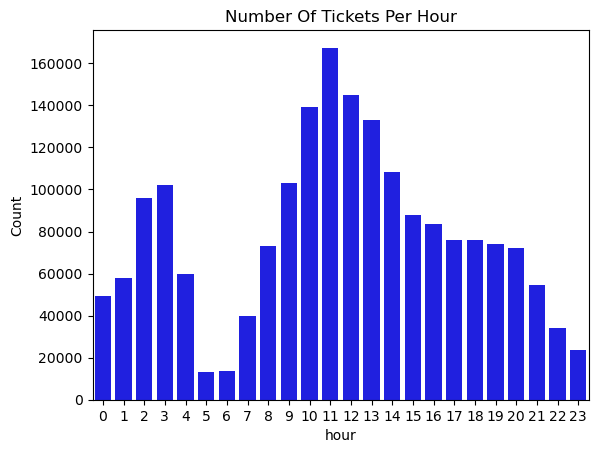

In [26]:
# visualize number of tickets per hour
ticket_count_per_hour = df1.groupby('hour')['infraction_code'].count().sort_values(ascending = False).reset_index().rename(columns = {'infraction_code':'Count'})
sns.barplot(
    data = ticket_count_per_hour,
    x = 'hour',
    y = 'Count',
    color='blue'
)
plt.title('Number Of Tickets Per Hour')
plt.show()

- The number of tickets peaks at 2 and 3 am and from 9 am to 2 pm. It decreases in the evening and early morning hours between 5 and 7 am.

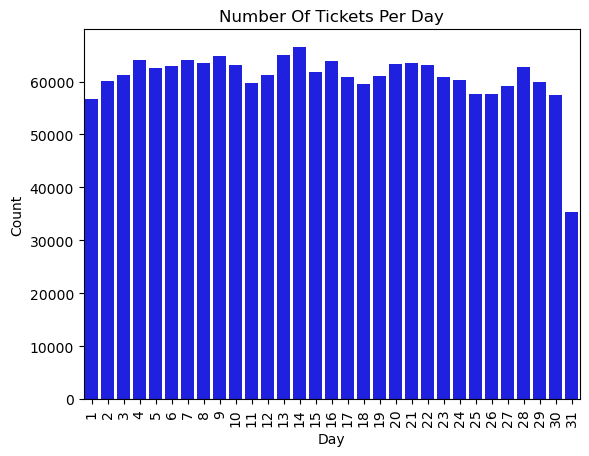

In [27]:
# visualize number of tickets per day
ticket_count_per_day = df1.groupby('Day')['infraction_code'].count().sort_values(ascending = False).reset_index().rename(columns = {'infraction_code':'Count'})
sns.barplot(
    data = ticket_count_per_day,
    x = 'Day',
    y = 'Count',
    color='blue'
)
plt.xticks(rotation = 90)
plt.title('Number Of Tickets Per Day')
plt.show()

As observed in the plot, there is no significant difference in the number of tickets throughout the month. Only a decline is noticeable on the 31st, likely due to traffic enforcement officers meeting their quota and implementing more relaxed penalty enforcement.

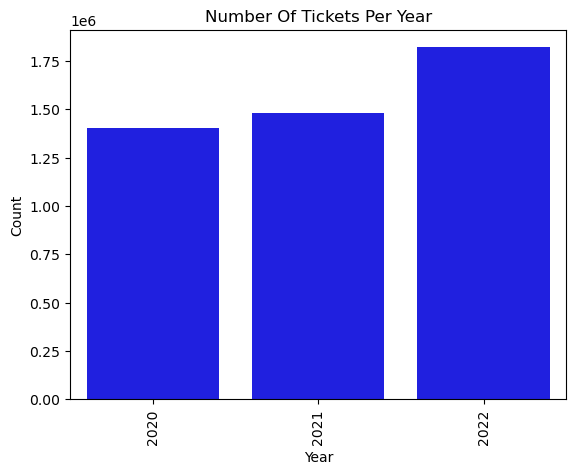

In [28]:
# visualize number of tickets per year
ticket_count_per_day = df.groupby('Year')['infraction_code'].count().sort_values(ascending = False).reset_index().rename(columns = {'infraction_code':'Count'})
sns.barplot(
    data = ticket_count_per_day,
    x = 'Year',
    y = 'Count',
    color='blue'
)
plt.xticks(rotation = 90)
plt.title('Number Of Tickets Per Year')
plt.show()

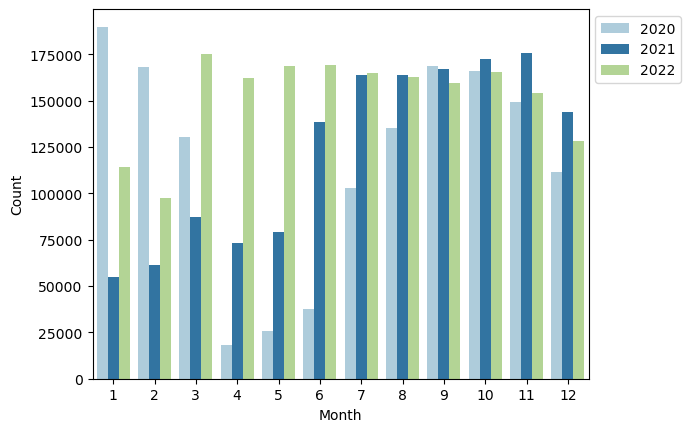

In [29]:
# visualize number of tickets per month compared for three years
df_temp = df.groupby(["Year", "Month"])["infraction_code"].count().reset_index().rename(columns = {'infraction_code':'Count'})

ax = sns.barplot(
    data = df_temp,
    x = "Month",
    y = "Count", 
    hue = "Year",
    palette="Paired"
)
# ax.legend(loc="upper right")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()
# df_temp

We observed a drastic decline in April 2020 due to Covid-19. It started climbing up in June but didn't reach the pre-pandemic levels.

<Axes: xlabel='Month', ylabel='Day'>

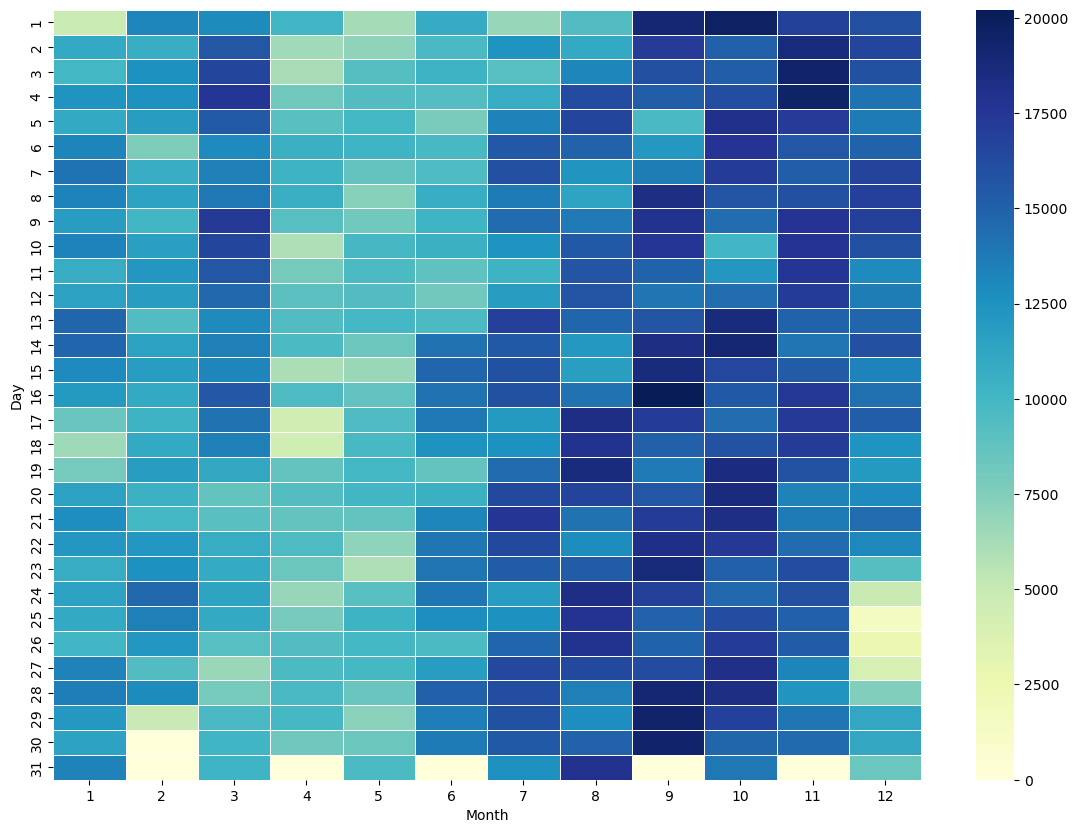

In [30]:
# visualize the ticket numbers for each day of the month for the entire period
df_temp =  df.groupby(["Month", "Day"])["infraction_code"].count().reset_index(name = "Count")
pivot_table = df_temp.pivot_table(values='Count', index='Day', columns='Month', aggfunc='sum', fill_value=0)
# sns.heatmap(pivot_table)
plt.figure(figsize=(14, 10))

# use pivot table to plot a heatmap
sns.heatmap(pivot_table, cmap='YlGnBu',  fmt=".2f", linewidths=.5)

A few observations from the plot:
- We can see that the number of tickets declines on 31st of the month, which we already observed above. 
- The number of tickets inceases on 16th of September. That can be attributed to the beginning of the school year.
- Also, it decreases during Christmas time.
- In general, the number of tickets is higher from June to November.

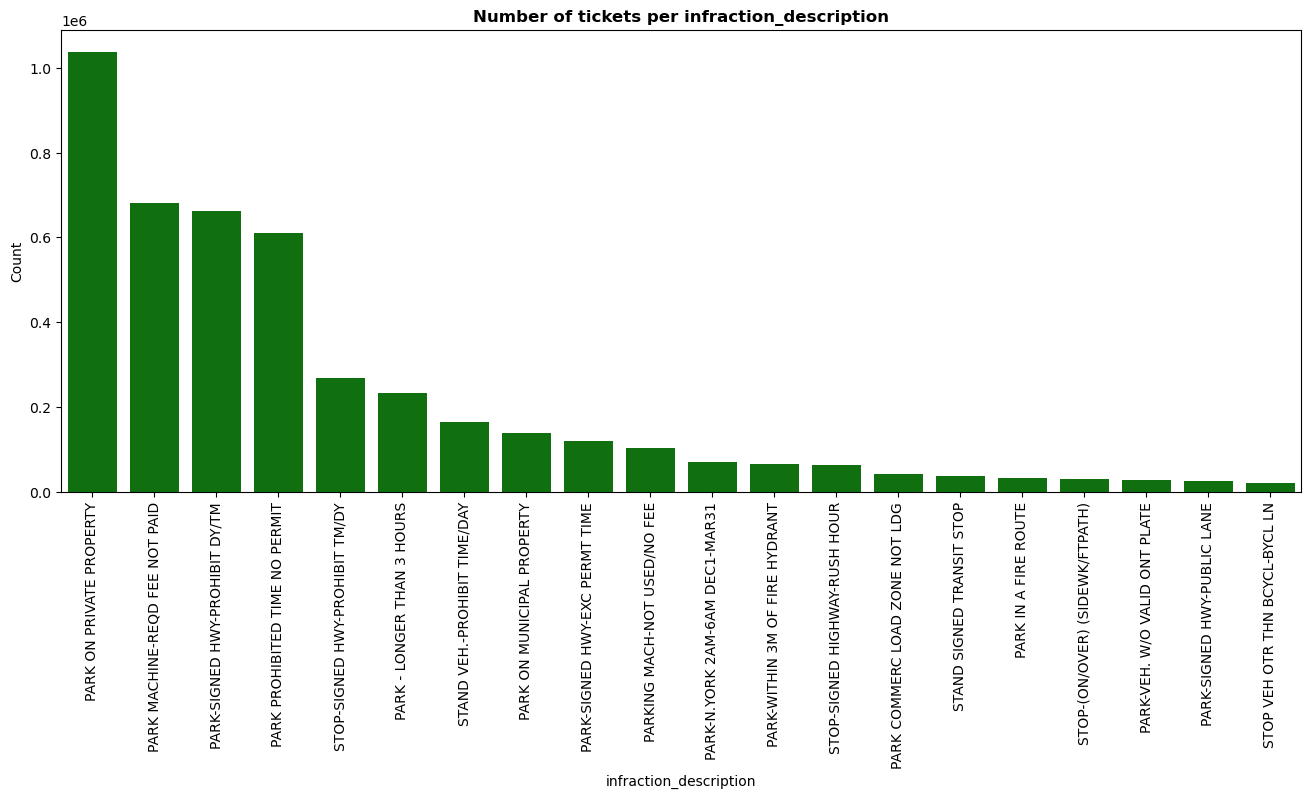

In [31]:
# visualize top 20 infractions
infrac_desc_count = df.groupby('infraction_description')['infraction_code'].count().sort_values(ascending = False).reset_index().rename(columns = {'infraction_code':'Count'})
top_20 = infrac_desc_count[:20]
plt.figure(figsize=(16,6))
sns.barplot(
    data = top_20,
    x = 'infraction_description',
    y = 'Count',
    color = "green",
)
plt.title('Number of tickets per infraction_description', weight = "bold")
plt.xticks(rotation = 90)
plt.show()

We observe from the plot that the highest infraction was Park on Private Property.

## Modelling 

Let's prepare our Dataset for modelling.

In [32]:
# drop unnecessary columns.
df2 = df1.drop(["tag_number_masked", "infraction_code", "infraction_description", "province"], axis = 1)
# check
df2.head(3)

,set_fine_amount,hour,min,Day,Month,Year,latitude,longitude
0,30,0,5,1,1,2020,43.792145,-79.234291
1,30,18,6,2,1,2020,43.792145,-79.234291
2,30,18,8,2,1,2020,43.792145,-79.234291


In [33]:
# check the shape of the dataset
df2.shape

(1883653, 8)

There are 1883653 rows and 8 columns.

In [34]:
# save the clean data for advance modelling
df2.to_csv("full_data.csv", index = False)

In [35]:
# since the dataset is too big, it takes too long to train the model so I decided to keep less rows for training
df3 = df2.sample(frac=0.3)

<Axes: >

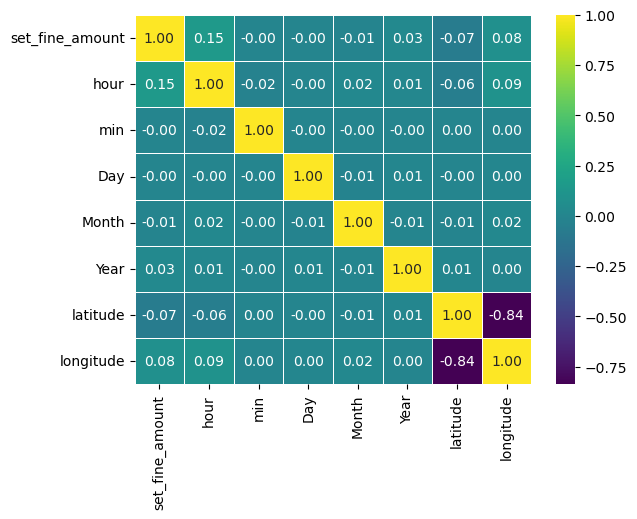

In [36]:
# check correlation
# draw a heatmap
corr = df3.corr()
sns.heatmap(corr, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)

- After examining the above correlation heatmap I observed that there is a positve correlation of `set_fine_amount` column with `hour` column, also there is some poitive correlation between `longitude` and `year` columns. However other variables have slightly  negative correlation with target column.

Check the frequent fine amounts.

In [37]:
# check fine amount values
freq_count_set_fine_amount = df2['set_fine_amount'].value_counts()

In [38]:
# print fine amount values
freq_count_set_fine_amount

set_fine_amount
30     1178716
100     290626
50      156322
75       82374
40       71991
150      48983
450      21196
250      16459
60       16051
0          546
300        250
55          68
90          51
15          15
200          5
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

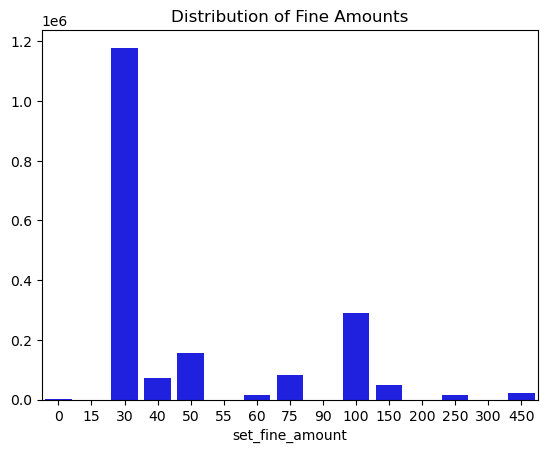

In [39]:
# visualize fine amounts
sns.barplot(
    x = freq_count_set_fine_amount.index,
    y = freq_count_set_fine_amount.values,
    color='blue'
)
plt.title("Distribution of Fine Amounts")
plt.show

In [40]:
# pull out the X and y

X = df3.drop('set_fine_amount', axis = 1)
y = df3['set_fine_amount']


In [41]:
# replace the set_fine_amount with classes to use in the model
replace_dict = {0: 0, 15: 1, 30: 2, 40: 3, 50: 4, 55: 5, 60: 6, 75: 7, 90: 8, 100: 9, 150: 10, 200: 11, 250: 12, 300: 13, 450: 14}
y = y.replace(replace_dict)

In [42]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Functions 


In [43]:
# create a function to use for all baseline models to print the Classification Report
def show_model_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Classification Report")
    report = classification_report(y_test, y_pred)
    print(report)

In [44]:
# create grid_search_cv function to get the best estimator for all baseline models
def grid_search_cv(model, param, X_train, y_train):
    gs = GridSearchCV(model,param, cv = 2)
    gs.fit(X_train,y_train)
    
    gs_results = pd.DataFrame(gs.cv_results_)
    gs_results = gs_results.sort_values(by = "mean_test_score", ascending = False)
    
    print("Performance of top 10 Model on  Parameters")
    display(gs_results.head(10))
    
    best_estimator = gs.best_estimator_
    
    return best_estimator

### Baseline Models

In [46]:
# first base model to try is Logistic Regression
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

base_model = LogisticRegression()
base_model.fit(X_train, y_train)

LogisticRegression()

In [47]:
# print the report
show_model_report(base_model, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           2       0.63      1.00      0.77     70850
           3       0.00      0.00      0.00      4422
           4       0.00      0.00      0.00      9516
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00       992
           7       0.00      0.00      0.00      4792
           8       0.00      0.00      0.00         6
           9       0.22      0.00      0.00     17166
          10       0.00      0.00      0.00      2908
          12       0.00      0.00      0.00      1013
          13       0.00      0.00      0.00        18
          14       0.00      0.00      0.00      1297

    accuracy                           0.63    113020
   macro avg       0.07      0.08      0.06    113020
weighted avg       0.43      0.63      0.48    113020



The accuracy is too low and it performs good only for one class.

### Experimenting With Other Algorithms

In [48]:
# import libraries
from sklearn.ensemble import (
            AdaBoostClassifier,
            RandomForestClassifier
)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import display

In [49]:
# fit Random Forest
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)
# print Classification Report
show_model_report(model1, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.18      0.05      0.08        38
           2       0.85      0.96      0.90     70850
           3       0.82      0.60      0.69      4422
           4       0.78      0.52      0.62      9516
           5       1.00      0.50      0.67         2
           6       0.64      0.34      0.44       992
           7       0.96      0.93      0.95      4792
           8       0.00      0.00      0.00         6
           9       0.77      0.68      0.73     17166
          10       0.79      0.49      0.60      2908
          12       0.80      0.28      0.41      1013
          13       0.50      0.17      0.25        18
          14       0.66      0.29      0.40      1297

    accuracy                           0.84    113020
   macro avg       0.67      0.45      0.52    113020
weighted avg       0.83      0.84      0.82    113020



The accuracy is not bad but it performs poor for some classes.

In [50]:
# fit Ada Boost
model2 = AdaBoostClassifier()
model2.fit(X_train, y_train)
# print Classification Report
show_model_report(model2, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00         0
           2       0.63      0.99      0.77     70850
           3       0.00      0.00      0.00      4422
           4       0.00      0.00      0.00      9516
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00       992
           7       0.00      0.00      0.00      4792
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00     17166
          10       0.00      0.00      0.00      2908
          12       0.00      0.00      0.00      1013
          13       0.00      0.00      0.00        18
          14       0.00      0.00      0.00      1297

    accuracy                           0.62    113020
   macro avg       0.04      0.07      0.05    113020
weighted avg       0.39      0.62      0.48    113020



The accuracy is very bad and performance is poor for all classes.

In [51]:
# fit XGBoost
model3 = XGBClassifier()
model3.fit(X_train, y_train)
# print Classification Report
show_model_report(model3, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           2       0.85      0.96      0.90     70850
           3       0.79      0.65      0.72      4422
           4       0.79      0.51      0.62      9516
           5       0.00      0.00      0.00         2
           6       0.63      0.59      0.61       992
           7       0.96      0.95      0.96      4792
           8       0.00      0.00      0.00         6
           9       0.78      0.67      0.72     17166
          10       0.74      0.52      0.61      2908
          12       0.73      0.27      0.39      1013
          13       0.67      0.11      0.19        18
          14       0.68      0.49      0.57      1297

    accuracy                           0.84    113020
   macro avg       0.59      0.44      0.48    113020
weighted avg       0.83      0.84      0.83    113020



- After reviewing the classification reports, it's clear that RandomForest and XGBoost are performing well.  Nonetheless, there is a noticeable imbalance in the dataset, where the number of records varies across different classes, potentially leading to poor model performance.

- To address this issue, I intend to balance the dataset by keeping an equal number of records for each class. Furthermore, I will remove any class with an insufficient number of records during this balancing process.

In [52]:
# check fine amounts
df2["set_fine_amount"].value_counts()

set_fine_amount
30     1178716
100     290626
50      156322
75       82374
40       71991
150      48983
450      21196
250      16459
60       16051
0          546
300        250
55          68
90          51
15          15
200          5
Name: count, dtype: int64

- The table above illustrates varying numbers of records for each `set_fine_amount`, indicating a state of data imbalance. To address this problem, my approach includes keeping 16000 records for each category. Any category with fewer than 16000 records will be excluded from the dataset.

In [53]:
# pick equal amount of rows for each class
freq_count_set_fine_amount = df2["set_fine_amount"].value_counts()
dfs = []

for CLASS, count in zip(freq_count_set_fine_amount.index, freq_count_set_fine_amount.values):
    if count >= 16000:
        df_temp = df2[df2['set_fine_amount'] == CLASS].iloc[:16000]
        dfs.append(df_temp)
    
# ref: https://www.dataquest.io/blog/tutorial-advanced-for-loops-python-pandas/
# https://www.techversantinfotech.com/python-naming-conventions-points-you-should-know

In [54]:
# concatenate dfs
df4 = pd.concat(dfs)
new_freq_count = df4['set_fine_amount'].value_counts()
# check
new_freq_count

set_fine_amount
30     16000
100    16000
50     16000
75     16000
40     16000
150    16000
450    16000
250    16000
60     16000
Name: count, dtype: int64

In [55]:
# pick a sample for tuning
dfs = []
for cls in df4["set_fine_amount"].unique():
    temp_df = df4[df4["set_fine_amount"] == cls].sample(1000)
    dfs.append(temp_df)
    
df_tune = pd.concat(dfs)
X_tune = df_tune.drop("set_fine_amount", axis = 1)
y_tune = df_tune["set_fine_amount"]
replace_dict = {30: 0, 40: 1, 50: 2, 60: 3, 75: 4, 100: 5, 150: 6, 250: 7, 450: 8}
y_tune = y_tune.replace(replace_dict)

In [56]:
# pull out the X and y

X = df4.drop('set_fine_amount', axis = 1)
y = df4['set_fine_amount']
replace_dict = {30: 0, 40: 1, 50: 2, 60: 3, 75: 4, 100: 5, 150: 6, 250: 7, 450: 8}
y = y.replace(replace_dict)
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [57]:
# create a function to visualize feature importance for all models
def generate_feature_importance(model):
    table = pd.DataFrame(
        list(zip(X_train.columns,model.feature_importances_)),
        columns = ["Feature", "Importance"]
    ).sort_values(by = "Importance", ascending=False)
    
    # create a bar plot using Seaborn
    sns.set(style="whitegrid")
    ax = sns.barplot(data = table,x="Feature", y="Importance", palette="Blues")
    
    # display the values on top of the bars
    for i, v in enumerate(table["Importance"]):
        ax.text(i, v + 0.001, str(round(v*100,2))+"%", ha='center', va='bottom')
    
    # customize the plot
    ax.set(title=f"Feature Importance {type(model).__name__}", xlabel="Feature", ylabel="Importance")
    
    # show the plot
    plt.show()

### RandomForest

In [58]:
# instantiate
model1 = RandomForestClassifier()
# fit
model1.fit(X_train, y_train)
# print report
show_model_report(model1, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3183
           1       0.91      0.92      0.92      3152
           2       0.84      0.84      0.84      3268
           3       0.92      0.93      0.93      3121
           4       0.99      1.00      0.99      3220
           5       0.87      0.85      0.86      3230
           6       0.91      0.87      0.89      3221
           7       0.88      0.91      0.89      3256
           8       0.87      0.83      0.85      3149

    accuracy                           0.90     28800
   macro avg       0.90      0.90      0.90     28800
weighted avg       0.90      0.90      0.90     28800



The accuracy is high and performace is good for all classes.

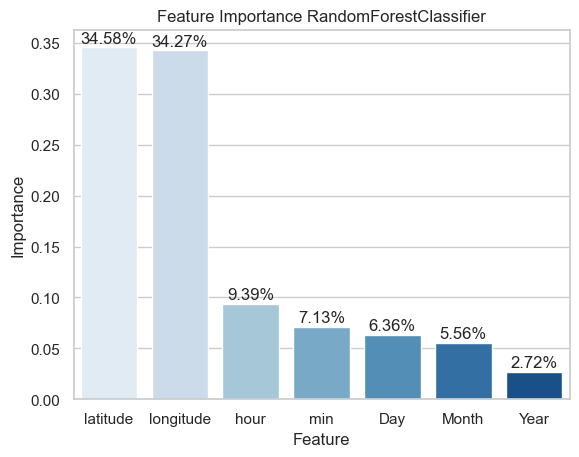

In [60]:
# plot feature importance
generate_feature_importance(model1)

By looking at the feature importance table we can see that Latitude and Longitude are the most important features with 34.58 and 34.27 respectively.

In [62]:
# hyperparameter tuning
model1 = RandomForestClassifier()
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [1,2,3],
    'n_estimators': [64, 128,256, 512],
}
best_model1 = grid_search_cv(model1, param_grid, X_tune, y_tune)
best_model1.fit(X_train, y_train)
show_model_report(best_model1, X_test, y_test)

Performance of top 10 Model on  Parameters


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
45,1.081206,0.005510,0.093155,0.002966,20,3,128,"{'max_depth': 20, 'min_samples_split': 3, 'n_e...",0.768444,0.772889,0.770667,0.002222,1
43,4.535056,0.000514,0.365656,0.002024,20,2,512,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.762444,0.776222,0.769333,0.006889,2
47,4.333866,0.009534,0.365842,0.009200,20,3,512,"{'max_depth': 20, 'min_samples_split': 3, 'n_e...",0.765333,0.772000,0.768667,0.003333,3
42,2.259366,0.015193,0.183308,0.001945,20,2,256,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.764444,0.770889,0.767667,0.003222,4
46,2.165371,0.003247,0.172724,0.000837,20,3,256,"{'max_depth': 20, 'min_samples_split': 3, 'n_e...",0.764889,0.764000,0.764444,0.000444,5
41,1.125218,0.008500,0.100766,0.000665,20,2,128,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.765778,0.761778,0.763778,0.002000,6
31,4.106477,0.023666,0.369130,0.004341,15,2,512,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",0.763778,0.762000,0.762889,0.000889,7
30,2.051031,0.000611,0.176440,0.001411,15,2,256,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",0.760000,0.762667,0.761333,0.001333,8
35,3.961147,0.008566,0.366226,0.013689,15,3,512,"{'max_depth': 15, 'min_samples_split': 3, 'n_e...",0.758222,0.763556,0.760889,0.002667,9
29,1.027354,0.004665,0.088084,0.000079,15,2,128,"{'max_depth': 15, 'min_samples_split': 2, 'n_e...",0.761556,0.758667,0.760111,0.001444,10


Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3183
           1       0.91      0.92      0.91      3152
           2       0.83      0.84      0.84      3268
           3       0.92      0.93      0.93      3121
           4       0.98      1.00      0.99      3220
           5       0.88      0.84      0.86      3230
           6       0.92      0.86      0.89      3221
           7       0.87      0.92      0.89      3256
           8       0.88      0.83      0.85      3149

    accuracy                           0.90     28800
   macro avg       0.90      0.90      0.90     28800
weighted avg       0.90      0.90      0.90     28800



RandomForest is performing good on the dataset. Using the default settings I was able to get 90% accuracy, 
however after doing some Hyperparameter tuning the accuray didn't change.



###  AdaBoost

In [64]:
# instantiate
model2 = AdaBoostClassifier()
# fit
model2.fit(X_train, y_train)
# print the report
show_model_report(model2, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3183
           1       0.43      0.47      0.45      3152
           2       0.39      0.24      0.30      3268
           3       0.31      0.63      0.42      3121
           4       0.76      0.53      0.62      3220
           5       0.38      0.55      0.45      3230
           6       0.28      0.11      0.16      3221
           7       0.42      0.57      0.49      3256
           8       0.47      0.24      0.32      3149

    accuracy                           0.45     28800
   macro avg       0.47      0.45      0.44     28800
weighted avg       0.47      0.45      0.44     28800



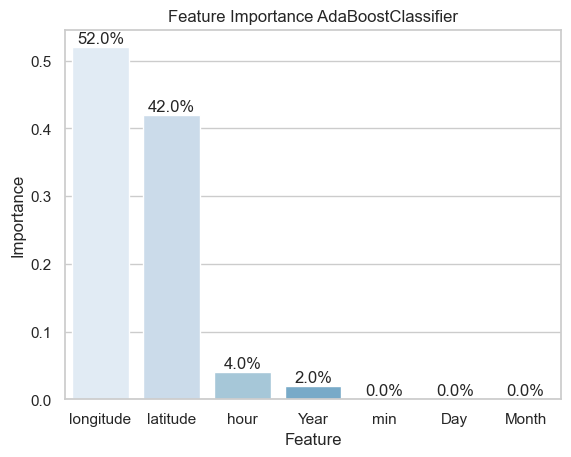

In [65]:
# plot feature importance
generate_feature_importance(model2)

The latitude and longitude are the most important features among all features with latitude having 42 % and longitude 52 % importance respectively.

In [67]:
# hyperparameter tuning
model2 = AdaBoostClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

best_model2 = grid_search_cv(model2, param_grid, X_tune, y_tune)
best_model2.fit(X_train, y_train)
show_model_report(best_model2, X_test, y_test)

Performance of top 10 Model on  Parameters


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,0.183694,0.003819,0.039065,0.007813,1.0,50,"{'learning_rate': 1.0, 'n_estimators': 50}",0.404667,0.391556,0.398111,0.006556,1
5,0.739058,0.007852,0.149033,0.008398,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.377556,0.392000,0.384778,0.007222,2
7,0.377795,0.005138,0.069164,0.006642,1.0,100,"{'learning_rate': 1.0, 'n_estimators': 100}",0.357778,0.407778,0.382778,0.025000,3
4,0.368099,0.006846,0.076669,0.001462,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.356667,0.363556,0.360111,0.003444,4
3,0.184210,0.003591,0.042325,0.008686,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.375556,0.341778,0.358667,0.016889,5
8,0.757412,0.005515,0.156721,0.000272,1.0,200,"{'learning_rate': 1.0, 'n_estimators': 200}",0.332000,0.378667,0.355333,0.023333,6
2,0.768817,0.012102,0.143684,0.003602,0.01,200,"{'learning_rate': 0.01, 'n_estimators': 200}",0.329778,0.316000,0.322889,0.006889,7
1,0.405225,0.005569,0.091329,0.002418,0.01,100,"{'learning_rate': 0.01, 'n_estimators': 100}",0.323111,0.318889,0.321000,0.002111,8
0,0.208547,0.001874,0.045744,0.000298,0.01,50,"{'learning_rate': 0.01, 'n_estimators': 50}",0.321778,0.290889,0.306333,0.015444,9


Classification Report
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3183
           1       0.43      0.47      0.45      3152
           2       0.39      0.24      0.30      3268
           3       0.31      0.63      0.42      3121
           4       0.76      0.53      0.62      3220
           5       0.38      0.55      0.45      3230
           6       0.28      0.11      0.16      3221
           7       0.42      0.57      0.49      3256
           8       0.47      0.24      0.32      3149

    accuracy                           0.45     28800
   macro avg       0.47      0.45      0.44     28800
weighted avg       0.47      0.45      0.44     28800



The performance of Adaboost is not good on the dataset. Using the default setting I was able to get 45% accuracy, however after some Hyperparameter tuning the accuracy didn't change.



### XGBoost

In [69]:
# instantiate
model3  = XGBClassifier()
# fit
model3.fit(X_train, y_train)
# print the report
show_model_report(model3, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3183
           1       0.92      0.92      0.92      3152
           2       0.84      0.88      0.86      3268
           3       0.95      0.95      0.95      3121
           4       0.99      1.00      1.00      3220
           5       0.88      0.85      0.86      3230
           6       0.91      0.89      0.90      3221
           7       0.91      0.94      0.93      3256
           8       0.91      0.85      0.88      3149

    accuracy                           0.92     28800
   macro avg       0.92      0.92      0.92     28800
weighted avg       0.92      0.92      0.92     28800



The accuracy is high and the model is performing good for all classes.

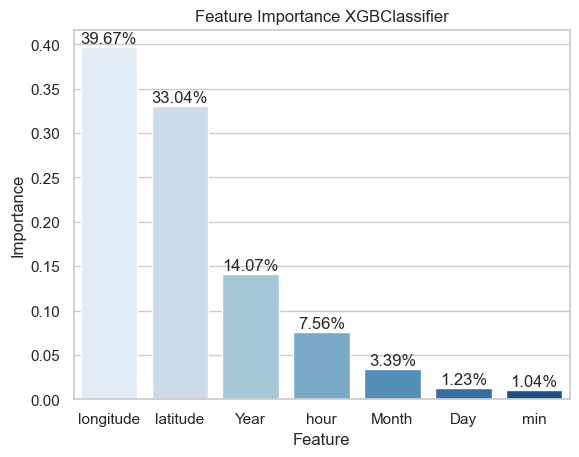

In [70]:
# plot feature importance
generate_feature_importance(model3)

The latitude and longitude are the most important features among all features with latitude having 33.04 % and longitude 39.68 % importance respectively.

In [71]:
# hyperparameter tuning
model3 = XGBClassifier() 
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [32, 128, 256],
}
best_model3 = grid_search_cv(model3, param_grid, X_tune, y_tune)
best_model3.fit(X_train, y_train)
show_model_report(best_model3, X_test, y_test)

Performance of top 10 Model on  Parameters


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
23,1.827386,0.041426,0.078642,1.613700e-02,0.8,0.2,4,256,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.869778,0.861556,0.865667,0.004111,1
26,2.033498,0.016674,0.074567,8.309603e-03,0.8,0.2,5,256,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.870889,0.858222,0.864556,0.006333,2
17,2.078000,0.046706,0.087091,8.961320e-03,0.8,0.1,5,256,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.867778,0.861111,0.864444,0.003333,3
50,1.719545,0.026962,0.062505,4.768372e-07,0.9,0.2,4,256,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.867333,0.860444,0.863889,0.003444,4
53,2.131585,0.020846,0.082999,4.869699e-03,0.9,0.2,5,256,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.866000,0.861778,0.863889,0.002111,4
77,1.761085,0.040919,0.064195,6.297350e-03,1.0,0.2,4,256,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.866000,0.861778,0.863889,0.002111,4
44,2.102860,0.013562,0.078132,7.152557e-07,0.9,0.1,5,256,"{'colsample_bytree': 0.9, 'learning_rate': 0.1...",0.866889,0.860889,0.863889,0.003000,4
25,1.031689,0.006967,0.042135,5.603194e-03,0.8,0.2,5,128,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.869333,0.858444,0.863889,0.005444,4
47,1.609942,0.014394,0.098203,4.446030e-03,0.9,0.2,3,256,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.867778,0.857778,0.862778,0.005000,9
52,1.071465,0.033815,0.051756,2.907515e-03,0.9,0.2,5,128,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.866667,0.858667,0.862667,0.004000,10


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3183
           1       0.91      0.90      0.91      3152
           2       0.84      0.87      0.85      3268
           3       0.94      0.94      0.94      3121
           4       0.99      1.00      1.00      3220
           5       0.88      0.84      0.86      3230
           6       0.90      0.87      0.89      3221
           7       0.90      0.93      0.92      3256
           8       0.91      0.83      0.87      3149

    accuracy                           0.91     28800
   macro avg       0.91      0.91      0.91     28800
weighted avg       0.91      0.91      0.91     28800



XGBoost is the best performing model among all of them. The accuracy on the default parameters was higher, however 
the accuracy on the tuned model slightly decreased. That means default parameters were performing better.

In [72]:
# using different hyperparameters for XGBoost
model = XGBClassifier()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}
best_model = grid_search_cv(model, param_grid, X_tune, y_tune)
show_model_report(best_model, X_test, y_test)

Performance of top 10 Model on  Parameters


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
26,0.867649,0.002225,0.040094,2.634525e-05,0.8,0.2,5,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.868667,0.856889,0.862778,0.005889,1
79,1.046722,0.004589,0.046878,3.576279e-07,1.0,0.2,5,0.9,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.863333,0.858667,0.861000,0.002333,2
25,1.030991,0.005273,0.048001,2.142668e-03,0.8,0.2,5,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.867111,0.854000,0.860556,0.006556,3
24,1.040757,0.004077,0.051742,4.757166e-03,0.8,0.2,5,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.864444,0.856222,0.860333,0.004111,4
52,1.038648,0.007329,0.049767,2.888799e-03,0.9,0.2,5,0.9,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.866444,0.854222,0.860333,0.006111,4
80,0.870332,0.023596,0.045930,3.448963e-03,1.0,0.2,5,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.866444,0.853333,0.859889,0.006556,6
53,0.848528,0.004445,0.036199,4.948854e-03,0.9,0.2,5,1.0,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.862444,0.856889,0.859667,0.002778,7
51,1.046708,0.013329,0.047986,1.673126e-02,0.9,0.2,5,0.8,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.863778,0.852444,0.858111,0.005667,8
77,0.688225,0.014343,0.031254,5.960464e-07,1.0,0.2,4,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.860222,0.849333,0.854778,0.005444,9
78,1.081718,0.010512,0.049951,7.646322e-03,1.0,0.2,5,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.857556,0.852000,0.854778,0.002778,10


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3183
           1       0.87      0.85      0.86      3152
           2       0.81      0.83      0.82      3268
           3       0.88      0.90      0.89      3121
           4       0.98      1.00      0.99      3220
           5       0.85      0.83      0.84      3230
           6       0.84      0.81      0.83      3221
           7       0.84      0.88      0.86      3256
           8       0.88      0.79      0.83      3149

    accuracy                           0.87     28800
   macro avg       0.87      0.87      0.87     28800
weighted avg       0.87      0.87      0.87     28800



In [73]:
# best model fit
best_model.fit(X_train, y_train)
show_model_report(best_model, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3183
           1       0.90      0.90      0.90      3152
           2       0.82      0.87      0.85      3268
           3       0.93      0.94      0.93      3121
           4       0.99      1.00      0.99      3220
           5       0.88      0.84      0.86      3230
           6       0.90      0.85      0.88      3221
           7       0.89      0.93      0.91      3256
           8       0.90      0.82      0.86      3149

    accuracy                           0.90     28800
   macro avg       0.90      0.90      0.90     28800
weighted avg       0.90      0.90      0.90     28800



Using other set of hyperparameters the accuracy decreased slightly, but the model is performing good overall.

In [74]:
# checking less hyperparameters for Random Forest
model = RandomForestClassifier()
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [64, 128, 256],
}
best_model = grid_search_cv(model, param_grid, X_tune, y_tune)
show_model_report(best_model, X_test, y_test)

Performance of top 10 Model on  Parameters


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
20,2.003101,0.018201,0.181729,8.154392e-03,15,3,256,"{'max_depth': 15, 'min_samples_split': 3, 'n_e...",0.761111,0.763111,0.762111,0.001000,1
22,0.958993,0.002802,0.083767,1.097631e-02,15,4,128,"{'max_depth': 15, 'min_samples_split': 4, 'n_e...",0.762667,0.754667,0.758667,0.004000,2
23,1.920172,0.006611,0.165901,5.103588e-03,15,4,256,"{'max_depth': 15, 'min_samples_split': 4, 'n_e...",0.757111,0.757778,0.757444,0.000333,3
18,0.486363,0.000230,0.039065,7.812619e-03,15,3,64,"{'max_depth': 15, 'min_samples_split': 3, 'n_e...",0.753333,0.760000,0.756667,0.003333,4
19,0.985418,0.002899,0.078130,1.192093e-07,15,3,128,"{'max_depth': 15, 'min_samples_split': 3, 'n_e...",0.752444,0.758222,0.755333,0.002889,5
25,0.929917,0.000272,0.082365,1.318574e-03,15,5,128,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",0.754889,0.748000,0.751444,0.003444,6
26,1.849077,0.005402,0.169687,2.214551e-03,15,5,256,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",0.750000,0.751333,0.750667,0.000667,7
24,0.462718,0.009145,0.045147,1.730919e-03,15,5,64,"{'max_depth': 15, 'min_samples_split': 5, 'n_e...",0.747111,0.740000,0.743556,0.003556,8
21,0.486781,0.007099,0.045520,1.380086e-03,15,4,64,"{'max_depth': 15, 'min_samples_split': 4, 'n_e...",0.742889,0.736000,0.739444,0.003444,9
17,1.332270,0.015308,0.140635,2.384186e-07,10,5,256,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.690889,0.702444,0.696667,0.005778,10


Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3183
           1       0.84      0.79      0.81      3152
           2       0.72      0.72      0.72      3268
           3       0.79      0.80      0.79      3121
           4       0.88      0.98      0.93      3220
           5       0.81      0.77      0.79      3230
           6       0.81      0.72      0.76      3221
           7       0.75      0.80      0.77      3256
           8       0.76      0.70      0.73      3149

    accuracy                           0.80     28800
   macro avg       0.80      0.80      0.80     28800
weighted avg       0.80      0.80      0.80     28800



Using different parameters for RandomForest also decreased the performance of the model.

In [75]:
# best model fit
best_model.fit(X_train, y_train)
show_model_report(best_model, X_test, y_test)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3183
           1       0.90      0.89      0.89      3152
           2       0.81      0.81      0.81      3268
           3       0.86      0.91      0.89      3121
           4       0.94      0.99      0.97      3220
           5       0.89      0.81      0.85      3230
           6       0.89      0.82      0.85      3221
           7       0.82      0.89      0.85      3256
           8       0.87      0.79      0.83      3149

    accuracy                           0.88     28800
   macro avg       0.88      0.88      0.88     28800
weighted avg       0.88      0.88      0.87     28800



### SUMMARY:


XGBoost was the best performing model with the highest accuracy score and with the best performance for all classes. I will use XGBoost for advanced model. 
- Refer to Step2_Modelling.ipynb for the next steps.